<a href="https://colab.research.google.com/github/Benned-H/Summer2019/blob/master/HandsFree%20Vision/Answering_Questions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# This box is all you should need to get everything up and running for experiments here.

### IMPORTS ###
from google.colab import drive
drive.mount('/content/gdrive')

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

os.chdir("gdrive/My Drive/Colab Notebooks/HandsFree/Photos")

### GET IMAGES ###
print("Importing images... (About 60 seconds remaining overall)")
michael = mpimg.imread("Office.png")
ashley = mpimg.imread("Ashley.png")
gwb = mpimg.imread("GWB.png")
seth = mpimg.imread("Seth.png")
tiger = mpimg.imread("Tiger.png")
steven = mpimg.imread("Steven.png")
wesley = mpimg.imread("Wesley.png")

images = [michael,ashley,gwb,seth,tiger,steven,wesley]

### SKIN SAMPLE BOUNDING BOXES ###
print("Defining bounding boxes...")
boxes = [np.zeros(4)] * len(images) # Stores r,c,h,w.
boxes[0] = [192,304,27,40] # These were all taken from above.
boxes[1] = [1100,550,100,200]
boxes[2] = [575,1550,225,200]
boxes[3] = [183,75,25,25]
boxes[4] = [375,395,100,75]
boxes[5] = [100,220,80,90]
boxes[6] = [80,90,35,35]

def getSamples(images,boxes):
  # Function likely not needed.
  samples = []
  
  for i in range(len(images)):
    img = images[i]
    box = boxes[i]
    sample = np.zeros((box[2],box[3],3)) # Create RGB array for cropped image.
    for r in range(sample.shape[0]):
      for c in range(sample.shape[1]):
        sample[r][c] = img[box[0]+r][box[1]+c]   
    samples.append(sample)
    
  return samples

### CONVERT SAMPLE COLOR SPACE ###
def RGB_to_YCbCr(image):
  # Converts a given RGB image to the YCbCr color space.
  if len(image[0,0]) != 3:
    print("Error: Image is not RGB.")
    return
  output = np.zeros((image.shape[0],image.shape[1],3))
  for r in range(image.shape[0]):
    for c in range(image.shape[1]):
      rgb = image[r,c]
      output[r,c,0] =  0.2568*rgb[0] + 0.5041*rgb[1] + 0.0979*rgb[2] + 0.0625
      output[r,c,1] = -0.1482*rgb[0] - 0.2910*rgb[1] + 0.4392*rgb[2] + 0.5
      output[r,c,2] =  0.4392*rgb[0] - 0.3678*rgb[1] - 0.0714*rgb[2] + 0.5
  
  output = output * 256 # Convert into clean 0-255 range.
  return output.astype(np.int64)

def RGB_to_YCbCr_MAT(image):
  # Matrix version of RGB --> YCbCr.
  if len(image[0,0]) != 3:
    print("Error: Image is not RGB.")
    return
  
  transform = np.array([[0.2568,0.5041,0.0979],
                        [-0.1482,-0.2910,0.4392],
                        [0.4392,-0.3678,-0.0714]])
  output = np.zeros((image.shape[0],image.shape[1],3))
  for r in range(image.shape[0]):
    for c in range(image.shape[1]):
      rgb = image[r,c]
      output[r,c] = np.matmul(transform,rgb) + [0.0625,0.5,0.5]
  
  output = output * 256 # Convert into clean 0-255 range.
  return output.astype(np.int64)

def RGB_to_CbCr(image):
  # Converts a given RGB image to the YCbCr color space.
  if len(image[0,0]) != 3:
    print("Error: Image is not RGB.")
    return
  output = np.zeros((image.shape[0],image.shape[1],2))
  for r in range(image.shape[0]):
    for c in range(image.shape[1]):
      rgb = image[r,c]
      output[r,c,0] = -0.1482*rgb[0] - 0.2910*rgb[1] + 0.4392*rgb[2] + 0.5
      output[r,c,1] =  0.4392*rgb[0] - 0.3678*rgb[1] - 0.0714*rgb[2] + 0.5
  
  output = output * 256 # Convert into clean 0-255 range.
  return output.astype(np.int64)

def RGB_to_CbCr_MAT(image):
  # Matrix version of RGB --> CbCr.
  if len(image[0,0]) != 3:
    print("Error: Image is not RGB.")
    return
  
  transform = np.array([[-0.1482,-0.2910,0.4392],
                        [0.4392,-0.3678,-0.0714]])
  output = np.zeros((image.shape[0],image.shape[1],2))
  for r in range(image.shape[0]):
    for c in range(image.shape[1]):
      rgb = image[r,c]
      output[r,c] = np.matmul(transform,rgb) + [0.5,0.5]
  
  output = output * 256 # Convert into clean 0-255 range.
  return output.astype(np.int64)
  
### CREATE SKIN COLOR PLANES ###
# Here's the code for dilating/eroding:
def splitKernel(kernel):
  """Splits given kernel into individual offsets from its center.
  Also gives maximum offsets in order left right up down."""
    
  if not isinstance(kernel, np.ndarray):
    print("Error: Invalid kernel. Need numpy array")
    return None
  
  # Require 2D array.
  if len(kernel.shape) != 2:
    print("Error: Invalid kernel. Need 2D array")
    return None
  
  height = kernel.shape[0]
  width = kernel.shape[1]
  
  # Require odd dimensions on kernel. Input pixel at center.
  if (height % 2 != 1) or (width % 2 != 1):
    print("Error: Invalid kernel. Need odd dimensions")
    return None
  
  center_r = int(height) // 2
  center_c = int(width) // 2
  outputs = []
  
  # Loop over all pixels
  for r in range(height):
    for c in range(width):
      if kernel[r][c] == 1:
        outputs.append((r - center_r, c - center_c))
        
  return outputs

def maxOffsets(offsets):
  # Do this to avoid if statements on all input pixels.
  left = 0
  right = 0
  up = 0
  down = 0
  
  # Find max offset in each direction.
  for o in offsets:
    left = max(left, -o[1])
    right = max(right, o[1])
    up = max(up, -o[0])
    down = max(down, o[0])
    
  return left,right,up,down

def dilate(image, kernel, times=1):
  """Dilate the given image using the given kernel.
  Note: Only uses binary images/kernel."""
  
  # Split the kernel into individual offset coordinates.
  kernel_parts = splitKernel(kernel)
  
  # Fetch the maximum offsets from any input pixel in our kernel.
  left,right,up,down = maxOffsets(kernel_parts)
  
  output = np.zeros(image.shape)
  
  # Main part of image checking, no if statements needed:
  for r in range(0 + up, image.shape[0] - down):
    for c in range(0 + left, image.shape[1] - right):
      for k in kernel_parts:
        curr_r = r + k[0]
        curr_c = c + k[1]
        if image[curr_r][curr_c] == 1:
          output[r][c] = 1
          
  # Now cover four sides and corners:
  
  # Left side:
  for r in range(0 + up, image.shape[0] - down):
    for c in range(0, left):
      for k in kernel_parts:
        curr_r = r + k[0]
        curr_c = c + k[1]
        if curr_c >= 0:
          if image[curr_r][curr_c] == 1:
            output[r][c] = 1
            
  # Right side:
  for r in range(0 + up, image.shape[0] - down):
    for c in range(image.shape[1] - right, image.shape[1]):
      for k in kernel_parts:
        curr_r = r + k[0]
        curr_c = c + k[1]
        if curr_c < image.shape[1]:
          if image[curr_r][curr_c] == 1:
            output[r][c] = 1
  
  # Top side:
  for r in range(0, up):
    for c in range(0 + left, image.shape[1] - right):
      for k in kernel_parts:
        curr_r = r + k[0]
        curr_c = c + k[1]
        if curr_r >= 0:
          if image[curr_r][curr_c] == 1:
            output[r][c] = 1
            
  # Bottom side:
  for r in range(image.shape[0] - down, image.shape[0]):
    for c in range(0 + left, image.shape[1] - right):
      for k in kernel_parts:
        curr_r = r + k[0]
        curr_c = c + k[1]
        if curr_r < image.shape[0]:
          if image[curr_r][curr_c] == 1:
            output[r][c] = 1
  
  # Left top corner:
  for r in range(0, up):
    for c in range(0, left):
      for k in kernel_parts:
        curr_r = r + k[0]
        curr_c = c + k[1]
        if curr_r >= 0 and curr_c >= 0:
          if image[curr_r][curr_c] == 1:
            output[r][c] = 1
          
  # Right top corner:
  for r in range(0, up):
    for c in range(image.shape[1] - right, image.shape[1]):
      for k in kernel_parts:
        curr_r = r + k[0]
        curr_c = c + k[1]
        if curr_r >= 0 and curr_c < image.shape[1]:
          if image[curr_r][curr_c] == 1:
            output[r][c] = 1
            
  # Left bottom corner:
  for r in range(image.shape[0] - down, image.shape[0]):
    for c in range(0, left):
      for k in kernel_parts:
        curr_r = r + k[0]
        curr_c = c + k[1]
        if curr_r < image.shape[0] and curr_c >= 0:
          if image[curr_r][curr_c] == 1:
            output[r][c] = 1
            
  # Right bottom corner:
  for r in range(image.shape[0] - down, image.shape[0]):
    for c in range(image.shape[1] - right, image.shape[1]):
      for k in kernel_parts:
        curr_r = r + k[0]
        curr_c = c + k[1]
        if curr_r < image.shape[0] and curr_c < image.shape[1]:
          if image[curr_r][curr_c] == 1:
            output[r][c] = 1
            
  if times > 1:
    return dilate(output, kernel, times-1)
  return output

def erode(image, kernel, times=1):
  """Erode the given image using the given kernel.
  Note: Only uses binary images/kernel."""
  
  # Split the kernel into individual offset coordinates.
  kernel_parts = splitKernel(kernel)
  
  # Fetch the maximum offsets from any input pixel in our kernel.
  left,right,up,down = maxOffsets(kernel_parts)
  
  output = np.ones(image.shape)
  
  # Main part of image checking, no if statements needed:
  for r in range(up, image.shape[0] - down):
    for c in range(left, image.shape[1] - right):
      for k in kernel_parts:
        curr_r = r + k[0]
        curr_c = c + k[1]
        if image[curr_r][curr_c] == 0:
          output[r][c] = 0
          
  # Now cover four sides and corners:
  
  # Left side:
  for r in range(0 + up, image.shape[0] - down):
    for c in range(0, left):
      for k in kernel_parts:
        curr_r = r + k[0]
        curr_c = c + k[1]
        if curr_c >= 0:
          if image[curr_r][curr_c] == 0:
            output[r][c] = 0
            
  # Right side:
  for r in range(0 + up, image.shape[0] - down):
    for c in range(image.shape[1] - right, image.shape[1]):
      for k in kernel_parts:
        curr_r = r + k[0]
        curr_c = c + k[1]
        if curr_c < image.shape[1]:
          if image[curr_r][curr_c] == 0:
            output[r][c] = 0
  
  # Top side:
  for r in range(0, up):
    for c in range(0 + left, image.shape[1] - right):
      for k in kernel_parts:
        curr_r = r + k[0]
        curr_c = c + k[1]
        if curr_r >= 0:
          if image[curr_r][curr_c] == 0:
            output[r][c] = 0
            
  # Bottom side:
  for r in range(image.shape[0] - down, image.shape[0]):
    for c in range(0 + left, image.shape[1] - right):
      for k in kernel_parts:
        curr_r = r + k[0]
        curr_c = c + k[1]
        if curr_r < image.shape[0]:
          if image[curr_r][curr_c] == 0:
            output[r][c] = 0
  
  # Left top corner:
  for r in range(0, up):
    for c in range(0, left):
      for k in kernel_parts:
        curr_r = r + k[0]
        curr_c = c + k[1]
        if curr_r >= 0 and curr_c >= 0:
          if image[curr_r][curr_c] == 0:
            output[r][c] = 0
          
  # Right top corner:
  for r in range(0, up):
    for c in range(image.shape[1] - right, image.shape[1]):
      for k in kernel_parts:
        curr_r = r + k[0]
        curr_c = c + k[1]
        if curr_r >= 0 and curr_c < image.shape[1]:
          if image[curr_r][curr_c] == 0:
            output[r][c] = 0
            
  # Left bottom corner:
  for r in range(image.shape[0] - down, image.shape[0]):
    for c in range(0, left):
      for k in kernel_parts:
        curr_r = r + k[0]
        curr_c = c + k[1]
        if curr_r < image.shape[0] and curr_c >= 0:
          if image[curr_r][curr_c] == 0:
            output[r][c] = 0
            
  # Right bottom corner:
  for r in range(image.shape[0] - down, image.shape[0]):
    for c in range(image.shape[1] - right, image.shape[1]):
      for k in kernel_parts:
        curr_r = r + k[0]
        curr_c = c + k[1]
        if curr_r < image.shape[0] and curr_c < image.shape[1]:
          if image[curr_r][curr_c] == 0:
            output[r][c] = 0
  
  if times > 1:
    return erode(output, kernel, times-1)
  return output

kernel_1x1 = np.array([[1]])
kernel_cross = np.array([[0,1,0],[1,1,1],[0,1,0]])
kernel_3x3 = np.array([[1,1,1],[1,1,1],[1,1,1]])

def createPlane_YMAT(image,box):
  # Input images and sample boxes, outputs dilated color planes.
  ycbcr = RGB_to_YCbCr_MAT(image)
  plane = np.zeros((255,255))
  
  for r in range(box[0],box[0]+box[2]): # Only scan pixels in the box.
    for c in range(box[1],box[1]+box[2]): # Only scan pixels in the box.
      cb = ycbcr[r,c][1]
      cr = ycbcr[r,c][2]
      plane[cb,cr] = 1
      
  # Uses the box-cross-erode-cross morphological edit, we could change this easily.
  plane = dilate(plane, kernel_cross)
  plane = dilate(plane, kernel_3x3)
  plane = erode(plane, kernel_cross)
  return plane

print("Creating skin color model planes...")
planes = []
for num,image in enumerate(images):
  planes.append(createPlane_YMAT(image,boxes[num]))

### SEGMENT IMAGES ###
def segment_YMAT(image, plane):
  # Segments the given hand colors within the given RGB image.
  ycbcr = RGB_to_YCbCr_MAT(image)
  output = np.zeros(image.shape)
  for r in range(output.shape[0]):
    for c in range(output.shape[1]):
      cb = ycbcr[r,c][1]
      cr = ycbcr[r,c][2]
      if plane[cb,cr] == 1:
        output[r,c] = 1
  return output

print("Done.")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
Importing images... (About 60 seconds remaining overall)
Defining bounding boxes...
Creating skin color model planes...
Done.


## True Experimentation

The full process works, so it's time to consider the decisions made along the way. What could be varied to see if optimization is possible? Here's the full list of steps:   
**Setup**
1. Obtain the image.
>a. Could the image start as YCbCr? *Yes*   
>b. Is RGB the only option I have from the Raspberry Pi camera? *Nope*
2. Find the bounding box for the skin sample.
>a. This process occurs elsewhere, and only once.
3. Convert this sample to YCbCr.   
>a. Which method of calculation should we use? (Numbers, bitshift, matrices) *Matrix version is fastest*   
>b. Is the Y calculation even necessary? Seems to only help in displaying the image. *No, it isn't*
4. Plot the pixels in the CbCr plane.
>a. Are there other planes that could be useful, as in are orthogonal planes potentially helpful here or not?
5. Dilate/erode the color plane to smooth out the free-form skin model.
>a. Much experimentation remains to be done on this front.   
>b. Are dilations/erosions using the 3x3 kernel computationally problematic/worth it compared to the cross?   
>c. All of this happens once, so it's not much of an issue.

**Usage**
1. Obtain new image with hand we've previously sampled.
2. Create a new array the size of the image.
3. For all pixels in the image, is this pixel included in our skin model? Set the array accordingly.
>a. Should we consider all pixels? Maybe sample every other diagonally? Some other sample pattern like a knight?   
>b. If we sample like that, how do we double back to check all relevant pixels?
4. Dilate/erode this result for improved accuracy of our segmentation.
>a. Much experimentation remains to be done here too.   
>b. Dilations/erosions here would be much more costly on the runtime of our model.

## Answers  
* When **actually receiving images from the Pi Camera**, my options are are a series of images, or as a continuous as-fast-as-possible in-memory stream. Also of note might be the ```picamera.array``` module, which can export directly into a YUV array.
* The *YUV color model* includes a Y luminance component and two chrominance components, U and V. YCbCr is a system developed to support both digital and analog televisions, and it was proceeded by YPbPr, which is basically the luma-chroma model applied to analog video. Thus **YCbCr is equivalent to YUV for our purposes**. [Source](https://wolfcrow.com/whats-the-difference-between-yuv-yiq-ypbpr-and-ycbcr/)
* Thus **we might not need to convert to YCbCr/YUV at all** if we can directly receive it from the camera. Will that be faster?

In [2]:
for index, i in enumerate(images):
  print(index, i.shape[0] * i.shape[1])
  
ordered_images = [images[3],images[6],images[0],images[5],images[4]]

0 180056
1 4860000
2 3124000
3 39775
4 960000
5 275100
6 50232


In [3]:
# Fastest method of conversion?
import time

total = 0
cbcr_norm_times = []
for i in range(len(ordered_images)):
  start = time.time()
  RGB_to_CbCr(ordered_images[i])
  end = time.time()
  total += end-start
  cbcr_norm_times.append(end-start)
print("CbCr normal:", total)
  
total = 0
cbcr_mat_times = []
for i in range(len(ordered_images)):
  start = time.time()
  RGB_to_CbCr_MAT(ordered_images[i])
  end = time.time()
  total += end-start
  cbcr_mat_times.append(end-start)
print("CbCr matrix:", total)
  
total = 0
ycbcr_norm_times = []
for i in range(len(ordered_images)):
  start = time.time()
  RGB_to_YCbCr(ordered_images[i])
  end = time.time()
  total += end-start
  ycbcr_norm_times.append(end-start)
print("YCbCr normal:", total)
  
total = 0
ycbcr_mat_times = []
for i in range(len(ordered_images)):
  start = time.time()
  RGB_to_YCbCr_MAT(ordered_images[i])
  end = time.time()
  total += end-start
  ycbcr_mat_times.append(end-start)
print("YCbCr matrix:", total)

CbCr normal: 18.444711685180664
CbCr matrix: 6.811318635940552
YCbCr normal: 27.14119529724121
YCbCr matrix: 6.903257608413696


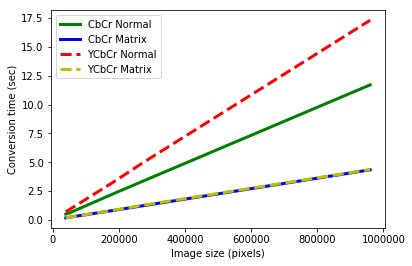

In [4]:
x = []
for i in ordered_images:
  x.append(i.shape[0]*i.shape[1])

plt.plot(x, cbcr_norm_times, 'g-', linewidth=3, label='CbCr Normal')
plt.plot(x, cbcr_mat_times, 'b-', linewidth=3, label='CbCr Matrix')
plt.plot(x, ycbcr_norm_times, 'r--', linewidth=3, label='YCbCr Normal')
plt.plot(x, ycbcr_mat_times, 'y--', linewidth=3, label='YCbCr Matrix')
plt.xlabel("Image size (pixels)")
plt.ylabel("Conversion time (sec)")
plt.legend()
plt.show()

So there we have it, on images of tractable size, the CbCr matrix function is the fastest conversion, although leaving out the Y feature barely helps at all. Perhaps the camera's YUV is faster still?

In [13]:
# Fastest way to create the planes?

ordered_boxes = [boxes[3],boxes[6],boxes[0],boxes[5],boxes[4]]

# Way 1: Sample then convert.
def createPlanes_sample_ND(images,boxes): # ND means no dilate
  samples = getSamples(images,boxes)
  planes = []
  for s in samples:
    cbcr = RGB_to_CbCr_MAT(s)
    plane = np.zeros((255,255))

    for r in range(s.shape[0]):
      for c in range(s.shape[1]):
        cb = cbcr[r,c][0]
        cr = cbcr[r,c][1]
        plane[cb,cr] = 1
    planes.append(plane)
      
  # Don't dilate for sake of testing speed of above processes.
  return planes

# Way 2: Whole image then sample.
def createPlanes_MAT_ND(images,boxes): # ND means no dilate
  # Input images and sample boxes, outputs dilated color planes.
  planes = []
  for i,image in enumerate(images):
    cbcr = RGB_to_CbCr_MAT(image)
    plane = np.zeros((255,255))
  
    for r in range(boxes[i][0],boxes[i][0]+boxes[i][2]):
      for c in range(boxes[i][1],boxes[i][1]+boxes[i][2]):
        cb = cbcr[r,c][0]
        cr = cbcr[r,c][1]
        plane[cb,cr] = 1
    planes.append(plane)
      
  # Don't dilate for sake of testing speed of above processes.
  return planes

start = time.time()
planes1 = createPlanes_sample_ND(ordered_images,ordered_boxes)
end = time.time()
print("Sample first took", end-start, "seconds.")

start = time.time()
planes2 = createPlanes_MAT_ND(ordered_images,ordered_boxes)
end = time.time()
print("Matrix image took", end-start, "seconds.")

Sample first took 0.10538864135742188 seconds.
Matrix image took 6.884119749069214 seconds.


Again, the decision is obvious. Sample the image and then convert that sample to YCbCr for creating the color planes.

In [0]:
# Now experimenting on the color plane dilation's effect on segmentation.

def createPlanes(images,boxes):
  # The winning version of the function.
  samples = getSamples(images,boxes)
  planes = []
  for s in samples:
    cbcr = RGB_to_CbCr_MAT(s)
    plane = np.zeros((255,255))

    for r in range(s.shape[0]):
      for c in range(s.shape[1]):
        cb = cbcr[r,c][0]
        cr = cbcr[r,c][1]
        plane[cb,cr] = 1
        
  return planes

In [0]:
planes = createPlanes(ordered_images,ordered_boxes)